# CoReference Network -- Richards

Notes
* Notebook currently treats the letter author and recipient as co-references. A strict author-recipient network at the moment (2021-09-27) would only have two nodes (Ellen Richards and Edward Atkinson).

In [1]:
import re, json, glob, csv, sys, os, warnings
import pandas as pd
import numpy as np
import itertools as iter
import networkx as nx
import xml.etree.ElementTree as ET
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import community
from networkx.readwrite import json_graph
from json import JSONEncoder
from operator import itemgetter
from collections import Counter

# Ignore warnings related to deprecated functions.
warnings.filterwarnings('ignore')

# Import project-specific functions. 
# Python files (.py) have to be in same folder to work.
lib_path = os.path.abspath(os.path.join(os.path.dirname('Correspondence_XML_parser.py'), '../Scripts'))
sys.path.append(lib_path)
from Correspondence_XML_parser import *

# # Read in config.py (git ignored file) for API username and pw.
# config_path = os.path.abspath(os.path.join(os.path.dirname('config.py'), '../Scripts'))
# sys.path.append(config_path)
# import config

# url = 'https://dsg.xmldb-dev.northeastern.edu/BaseX964/rest/psc/'
# user = config.username
# pw = config.password

## Gather XML Files

In [2]:
# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/"

input_directory = "Data/PSC/Richards/ESR-XML-Files-MHS/*.xml"

# Gather all .xml files using glob.
files = glob.glob(abs_dir + input_directory)

In [ ]:
# %%time

# # Must be connected to Northeastern's VPN.
# r = requests.get(url, 
#                  auth = (user, pw), 
#                  headers = {'Content-Type': 'application/xml'}
#                 )
    
# # Read in contents of pipeline.
# soup = BeautifulSoup(r.content, 'html.parser')

# # Split soup's content by \n (each line is a file path to an XML doc).
# # Use filter() to remove empty strings ('').
# # Convert back to list using list().
# files = list(filter(None, soup.text.split('\n')))

# # Filter list and retrieve only jqa/ files.
# files = [i for i in files if 'esr/' in i]

# len(files)

## Build Dataframe

In [3]:
%%time

# Build dataframe from XML files.
# build_dataframe() called from Correspondence_XML_parser
# df = build_dataframe(files, url, user, pw)

df = build_dataframe(files)

# Lowercase values in source, target, and reference columns.
df['source'] = df['source'].str.lower()
df['target'] = df['target'].str.lower()
df['references'] = df['references'].str.lower()

# Split references into list objects.
df['references'] = df['references'].str.split(r',|;')

df.head(3)

/Users/quinn.wi/Documents/Data/PSC/Richards/ESR-XML-Files-MHS/ESR-EDA-1893-09-24.xml 

CPU times: user 10.4 ms, sys: 3.17 ms, total: 13.6 ms
Wall time: 16.4 ms


,file,date,source,target,subjects,references,text
0,ESR-EDA-1892-01-08.xml,1892-01-08,richards-ellen,atkinson-edward,"1893 Chicago World's Fair,Aladdin Oven,New Eng...","[palmer-bertha, hovey-e, daniells-unknown]",Boston Jan 8 1892 My dear Mr Atkinson I enclo...
1,ESR-EDA-1892-04-12.xml,1892-04-12,richards-ellen,atkinson-edward,"Aladdin Oven,nutrition,cooking",[abel-mary],April 12— Dear Mr Atkinson I expect Mrs Abel ...
2,ESR-EDA-1892-04-07.xml,1892-04-07,richards-ellen,atkinson-edward,"Aladdin Oven,Nutrition,cooking","[conro-emma, abel-mary]","Boston, April 7, 1892 My dear Mr. Atkinson I ..."


## Reshape Dataframe for Network

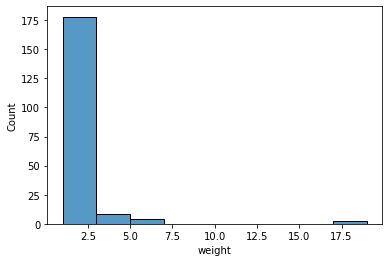

CPU times: user 161 ms, sys: 6.03 ms, total: 167 ms
Wall time: 169 ms


,source,target,weight
31,abel-mary,abel-john,1
46,palmer-alice,abel-john,1
56,richards-ellen,abel-john,1


In [12]:
%%time

# Explode list so that each list value becomes a row.
refs = df.explode('references')

# Create file-person matrix.
refs = pd.crosstab(refs['file'], refs['references'])

# Repeat with correspondence (source + target)
source = pd.crosstab(df['file'], df['source'])
target = pd.crosstab(df['file'], df['target'])

# Sum values of sources to refs or create new column with sources' values.
for col in source:
    if col in refs:
        refs[str(col)] = refs[str(col)] + source[str(col)]
    else:
        refs[str(col)] = source[str(col)]

# Repeat for targets.
for col in target:
    if col in refs:
        refs[str(col)] = refs[str(col)] + target[str(col)]
    else:
        refs[str(col)] = target[str(col)]

# Convert entry-person matrix into an adjacency matrix of persons.
refs = refs.T.dot(refs)

# # Change diagonal values to zero. That is, a person cannot co-occur with themself.
# np.fill_diagonal(refs.values, 0)

# Create new 'source' column that corresponds to index (person).
refs['source'] = refs.index

# # Reshape dataframe to focus on source, target, and weight.
# # Rename 'people' column name to 'target'.
df_graph = pd.melt(refs, id_vars = ['source'], var_name = 'target', value_name = 'weight') \
    .rename(columns = {'references':'target'}) \
    .query('(source != "u") & (target != "u")') \
    .query('(source != target) & (weight >= 1)')

# Remove rows with empty source or target.
df_graph['source'].replace('', np.nan, inplace=True)
df_graph['target'].replace('', np.nan, inplace=True)
df_graph.dropna(subset=['source', 'target'], inplace=True)


# Chart distribution of weights.
sns.histplot(data = df_graph, x = 'weight')

plt.show()

df_graph.head(3)


## Build Graph Object

In [13]:
%%time

%%time

# Initialize graph object.
G = nx.from_pandas_edgelist(df, 'source', 'target', 'weight')

# Add nodes.
nodes = list( dict.fromkeys( df['source'].values.tolist() + df['target'].values.tolist() ))
G.add_nodes_from(nodes)

print (nx.info(G))

# Set degree attributes.
nx.set_node_attributes(G, dict(G.degree(G.nodes())), 'degree')

# Sort nodes by degree and print top results.
sorted_degree = sorted(dict(G.degree(G.nodes())).items(),
                       key = itemgetter(1), reverse = True)

print ("Top 10 nodes by degree:")
for d in sorted_degree[:10]:
    print (f'\t{d}')


# Measure network density.
density = nx.density(G)
print (f"Network density: {density:.3f}")

# Related to diameter, check if network is connected and, therefore, can have a diameter.
print (f"Is the network connected? {nx.is_connected(G)}")

# Get a list of network components (communities).
# Find the largest component.
components = nx.connected_components(G)
largest_component = max(components, key = len)

# Create a subgraph of the largest component and measure its diameter.
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print (f"Network diameter of the largest component: {diameter:.3f}")

# Find triadic closure (similar to density).
triadic_closure = nx.transitivity(G)
print (f"Triadic closure: {triadic_closure:.3f}\n")

# Find centrality measures.
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
degree_cent_dict = nx.degree_centrality(G)

# Assign each centrality measure to an attribute.
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')
nx.set_node_attributes(G, degree_cent_dict, 'degree_cent')

# Find communities.
communities = community.naive_greedy_modularity_communities(subgraph)
# communities = community.k_clique_communities(subgraph, 5)
# communities = community.greedy_modularity_communities(subgraph)
# communities = community.kernighan_lin_bisection(subgraph)

# Create a dictionary that maps nodes to their community.
modularity_dict = {}
for i, c in enumerate(communities):
    for name in c:
        modularity_dict[name] = i
        
# Add modularity information to graph object.
nx.set_node_attributes(subgraph, modularity_dict, 'modularity')

Name: 
Type: Graph
Number of nodes: 29
Number of edges: 96
Average degree:   6.6207
Top 10 nodes by degree:
	('richards-ellen', 27)
	('atkinson-edward', 27)
	('daniells-unknown', 11)
	('abel-mary', 10)
	('hovey-e', 10)
	('davis-katherine', 7)
	('day-edna', 7)
	('unknown1', 7)
	('unknown2', 7)
	('unknown3', 7)
Network density: 0.236
Is the network connected? False
Triadic closure: 0.411

Network diameter of the largest component: 2.000
CPU times: user 3.11 s, sys: 23.6 ms, total: 3.14 s
Wall time: 3.19 s


## Write as Graph Object

In [14]:
%%time

# Convert graph object into a dictionary.
data = json_graph.node_link_data(G)
    
data_json = json.dumps(data)

with open(abs_dir + "GitHub/dsg-mhs/lab_space/projects/richards/coref/data/Richards_coRef-network.json", "w") as f:
    f.write(data_json)

CPU times: user 1.2 ms, sys: 1.19 ms, total: 2.39 ms
Wall time: 1.75 ms
